# **Análise de Dados - Hipertensão**

## Importando as bibliotecas necessárias

In [ ]:
!pip install pycaret

In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#from google.colab import files



## Importando os dados

In [52]:
uploaded = files.upload()

NameError: name 'files' is not defined

## Juntando os datasets

In [53]:
## dataset 'medications' == 'questionnaire'
demo = pd.read_csv('../data/demographic.csv')
diet = pd.read_csv('../data/diet.csv')
exam = pd.read_csv('../data/examination.csv')
labs = pd.read_csv('../data/labs.csv')
quest = pd.read_csv('../data/questionnaire.csv')


In [54]:
demo.drop(['SEQN'], axis=1, inplace=True)
diet.drop(['SEQN'], axis=1, inplace=True)
exam.drop(['SEQN'], axis=1, inplace=True)
labs.drop(['SEQN'], axis=1, inplace=True)
quest.drop(['SEQN'], axis=1, inplace=True)

In [55]:
df = pd.concat([demo, diet, exam, labs, quest], axis=1, join='inner')


In [56]:
df.head()

,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,8,2,1,69,NaN,4,4,1.0,NaN,1.0,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
1,8,2,1,54,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
2,8,2,1,72,NaN,3,3,2.0,NaN,1.0,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
3,8,2,1,9,NaN,3,3,1.0,119.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0
4,8,2,2,73,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,150.0,135.0,67.0,170.0,60.0,NaN,NaN,NaN


In [57]:
df.shape

(9813, 1811)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9813 entries, 0 to 9812
Columns: 1811 entries, SDDSRVYR to WHQ520
dtypes: float64(1753), int64(27), object(31)
memory usage: 135.6+ MB


## Eliminando colunas 'duplicadas' que servem apenas para conversão de unidades

In [59]:
cols = [c for c in df.columns if c[-2:]!= 'SI']

## Definindo as colunas que serão usadas

In [60]:
## hipertensão (blood pressure - versao completa)
#df = df[['ALQ101', 'BMXBMI', 'BMXWT', 'BPQ020', 'BPQ080', 'BPXSY1', 'BPXDI1', 'HSD010', 'LBXMC', 'MCQ160B', 'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ300A', 'MCQ370B', 'PEASCST1', 'RIAGENDR', 'RIDAGEYR', 'WHD010', 'SMQ040']]

## hipertensão (blood pressure - versao streaming)
df = df[['ALQ101', 'BMXBMI', 'BMXWT', 'BPQ020', 'BPQ080', 'LBXMC', 'MCQ160C', 'MCQ160F', 'MCQ300A', 'MCQ370B', 'RIAGENDR', 'RIDAGEYR', 'WHD010', 'SMQ040']]


# Dicionário de Features

In [61]:
# versao Completa
""" col_decoder = {
'ALQ101' : 'Drink_alcohol',             # Drink_Alcohol - Had at least 12 alcohol drinks/1 yr? ------ 0 = no  1 = yes      
'BMXBMI' : 'BMI',                       # BMI      - Body Mass Index / 
'BMXWT' : 'Weight_kg',                  # Weight in Kilograms 
'BPQ020' : 'HighBP',                   # HighBP   - High Blood Pressure  ------  0 = no high BP 1 = high BP
'BPQ080' : 'HighChol',          # HighCholesterol - High Cholesterol ----------- 0 = no high cholesterol  1 = high cholesterol
'BPXSY1' : 'Systolic_bp',               # Systolic: Blood pres (1st rdg) mm Hg 
'BPXDI1' : 'Diastolic_bp',              # Diastolic: Blood pres (1st rdg) mm Hg
'HSD010' : 'GenHlth',            # General Health Condition ------ 1 = Excelent  2 = Very good  3 = Good  4 = Fair  5 = Poor   
'LBXMC' : 'Hemoglobin_concentration',   # Mean cell hemoglobin concentration (g/dL)
'MCQ160B' : 'Congestive_heart_failure', # Ever told had congestive heart failure ------  0 = no  1 = yes
'MCQ160C' : 'Coronary_heart_disease',   # Ever told you had coronary heart disease ------  0 = no  1 = yes
'MCQ160D' : 'Angina',                   # Ever told you had angina/angina pectoris ------  0 = no  1 = yes
'MCQ160E' : 'Heart_attack',             # Ever told you had heart attack ------  0 = no  1 = yes 
'MCQ160F' : 'Stroke',                   # Ever told you had a stroke ------ 0 = no 1 = yes
'MCQ300A' : 'Relative_heart_attack',    # Close relative had heart attack ------  0 = no  1 = yes
'MCQ370B' : 'Exercising',               # Are you now increasing exercise ------  0 = no  1 = yes
'PEASCST1' : 'BP_status',               # Blood Pressure Status ------ 0 = parcial  1 = complete  3 = not done     
'RIAGENDR' : 'Sex',                  # Gender - 0 = female 1 = male
'RIDAGEYR' : 'Age',                     # Age - 13-level age category  1 = 18-24    9 = 60-64    13 = 80 or older
'SMQ040' : 'Smoker',                   # Smoking - 
'WHD010' : 'Height_cm',                 # Height in Centimeters
}
 """


# versao streaming
col_decoder = {
'ALQ101' : 'Drink_alcohol',             # Drink_Alcohol - Had at least 12 alcohol drinks/1 yr? ------ 0 = no  1 = yes      
'BMXBMI' : 'BMI',                       # BMI      - Body Mass Index / 
'BMXWT' : 'Weight_kg',                  # Weight in Kilograms 
'BPQ020' : 'HighBP',                   # HighBP   - High Blood Pressure  ------  0 = no high BP 1 = high BP
'BPQ080' : 'HighChol',          # HighCholesterol - High Cholesterol ----------- 0 = no high cholesterol  1 = high cholesterol
'LBXMC' : 'Hemoglobin_concentration',   # Mean cell hemoglobin concentration (g/dL)
'MCQ160C' : 'Coronary_heart_disease',   # Ever told you had coronary heart disease ------  0 = no  1 = yes
'MCQ160F' : 'Stroke',                   # Ever told you had a stroke ------ 0 = no 1 = yes
'MCQ300A' : 'Relative_heart_attack',    # Close relative had heart attack ------  0 = no  1 = yes
'MCQ370B' : 'Exercising',               # Are you now increasing exercise ------  0 = no  1 = yes
'RIAGENDR' : 'Sex',                  # Gender - 0 = female 1 = male
'RIDAGEYR' : 'Age',                     # Age - 13-level age category  1 = 18-24    9 = 60-64    13 = 80 or older
'SMQ040' : 'Smoker',                   # Smoking - 
'WHD010' : 'Height_cm',                 # Height in Centimeters
}

In [62]:
df = df.rename(columns = col_decoder)

## Convertendo dados para as medidas corretas

In [63]:
df['Height_cm'] = df['Height_cm'] * 2.54

In [64]:
df.head()

,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Hemoglobin_concentration,Coronary_heart_disease,Stroke,Relative_heart_attack,Exercising,Sex,Age,Height_cm,Smoker
0,1.0,26.7,78.3,1.0,1.0,33.4,2.0,1.0,2.0,2.0,1,69,175.26,3.0
1,1.0,28.6,89.5,1.0,1.0,32.5,2.0,2.0,2.0,2.0,1,54,180.34,2.0
2,1.0,28.9,88.9,1.0,1.0,34.3,2.0,2.0,1.0,2.0,1,72,177.80,3.0
3,NaN,17.1,32.2,NaN,NaN,34.0,NaN,NaN,NaN,NaN,1,9,NaN,NaN
4,1.0,19.7,52.0,1.0,2.0,33.0,2.0,2.0,1.0,2.0,2,73,170.18,NaN


## Lidando com Nulls

In [65]:
## Quando o paciente se recusa a responder uma questão ou quando 'não se aplica', são usadas combinações de números 7 e 9
df.replace({7:None, 9:None, 77:None, 99:None, 777:None, 999:None, 7777:None, 9999:None, 77777:None, 99999:None, 777777:None, 999999:None, 55:None, 555:None, 5555:None, 8:None, 88:None}, inplace=True)


In [66]:
df = df.dropna()

In [67]:
df.nunique()

Drink_alcohol                 2
BMI                         340
Weight_kg                   843
HighBP                        2
HighChol                      2
Hemoglobin_concentration     63
Coronary_heart_disease        2
Stroke                        2
Relative_heart_attack         2
Exercising                    2
Sex                           2
Age                          59
Height_cm                    26
Smoker                        3
dtype: int64

In [68]:
# versao completa 
#df[['Drink_alcohol',	'HighBP',	'HighChol',	'Congestive_heart_failure', 'Coronary_heart_disease',	'Angina',	'Heart_attack',	'Stroke',	'Relative_heart_attack',	'Exercising',	'BP_status']] = df[['Drink_alcohol',	'HighBP',	'HighChol',	'Congestive_heart_failure', 'Coronary_heart_disease',	'Angina',	'Heart_attack',	'Stroke',	'Relative_heart_attack',	'Exercising',	'BP_status']].replace(2.0,0)

# versao streaming
df[['Drink_alcohol',	'HighBP',	'HighChol',	'Coronary_heart_disease', 'Stroke',	'Relative_heart_attack',	'Exercising']] = df[['Drink_alcohol',	'HighBP',	'HighChol',	'Coronary_heart_disease', 'Stroke',	'Relative_heart_attack', 'Exercising']].replace(2.0,0)

In [69]:
df.head()

,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Hemoglobin_concentration,Coronary_heart_disease,Stroke,Relative_heart_attack,Exercising,Sex,Age,Height_cm,Smoker
0,1.0,26.7,78.3,1.0,1.0,33.4,0.0,1.0,0.0,0.0,1,69,175.26,3.0
1,1.0,28.6,89.5,1.0,1.0,32.5,0.0,0.0,0.0,0.0,1,54,180.34,2.0
2,1.0,28.9,88.9,1.0,1.0,34.3,0.0,0.0,1.0,0.0,1,72,177.8,3.0
5,1.0,41.7,105.0,1.0,1.0,34.2,1.0,0.0,0.0,1.0,1,56,162.56,3.0
9,1.0,22.0,65.3,0.0,0.0,35.3,0.0,0.0,0.0,1.0,2,56,154.94,1.0


## Removendo linhas e colunas com grande quantidade de nulls

In [70]:
def filter_columns(df, cutoff=0.9):
    tot_rows = df.shape[0]
    removed_cols = []
   
    for col in df.columns:
        num_na = df[col].isna().sum()
        if (num_na/tot_rows) > cutoff:
            removed_cols.append(col)
    return df.drop(removed_cols, axis=1)
    
def filter_rows(df, cutoff=0.9):
    tot_cols = df.shape[1]
    df = df[df.isnull().sum(axis=1) < tot_cols*cutoff]
    return df

In [71]:
df.isnull().sum()

Drink_alcohol               0
BMI                         0
Weight_kg                   0
HighBP                      0
HighChol                    0
Hemoglobin_concentration    0
Coronary_heart_disease      0
Stroke                      0
Relative_heart_attack       0
Exercising                  0
Sex                         0
Age                         0
Height_cm                   0
Smoker                      0
dtype: int64

In [72]:
df = df[df['Age'] > 18]

In [73]:
df.shape

(1654, 14)

In [74]:
df.sample(10)

,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Hemoglobin_concentration,Coronary_heart_disease,Stroke,Relative_heart_attack,Exercising,Sex,Age,Height_cm,Smoker
3283,0.0,30.1,74.2,1.0,0.0,33.1,0.0,0.0,0.0,1.0,2,61,162.56,3.0
9012,1.0,29.4,69.3,0.0,0.0,34.0,0.0,0.0,0.0,0.0,1,46,177.8,1.0
8659,1.0,21.5,58.8,0.0,0.0,33.4,0.0,0.0,0.0,1.0,1,52,182.88,1.0
974,1.0,26.9,67.2,1.0,1.0,33.0,0.0,0.0,0.0,1.0,1,72,172.72,3.0
8768,1.0,30.5,72.9,0.0,0.0,32.2,0.0,0.0,0.0,0.0,1,39,175.26,1.0
8009,1.0,27.2,69.2,0.0,0.0,31.7,0.0,0.0,1.0,0.0,1,52,180.34,3.0
3761,1.0,29.1,77.3,1.0,1.0,33.6,0.0,0.0,1.0,0.0,1,62,185.42,2.0
7512,1.0,22.4,65.2,0.0,0.0,34.0,0.0,0.0,0.0,1.0,2,26,172.72,1.0
2432,1.0,23.5,84.3,0.0,0.0,32.9,0.0,0.0,0.0,1.0,1,32,165.1,1.0
4878,0.0,21.5,52.9,0.0,1.0,33.3,0.0,0.0,0.0,0.0,1,67,175.26,3.0


In [75]:
df.describe()

,Drink_alcohol,HighBP,HighChol,Coronary_heart_disease,Stroke,Relative_heart_attack,Exercising
count,1654.000000,1654.000000,1654.000000,1654.000000,1654.000000,1654.000000,1654.000000
mean,0.865780,0.419589,0.388150,0.062273,0.044740,0.145103,0.567715
std,0.340992,0.493641,0.487476,0.241724,0.206795,0.352311,0.495543
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Machine Learning e seleção do melhor modelo

In [76]:
from pycaret.classification import *

In [77]:
cat_features = ['Sex', 'Age'] 

## inserir depois, em SETUP -> ,categorical_features=cat_features

In [78]:
s = setup(data = df, target='HighBP', train_size=0.75, categorical_features=cat_features)

,Description,Value
0,session_id,2553
1,Target,HighBP
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(1654, 14)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


In [79]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6887,0.7340,0.5487,0.6583,0.5975,0.3473,0.3518,0.2970
lda,Linear Discriminant Analysis,0.6847,0.7377,0.5830,0.6389,0.6074,0.3454,0.3479,0.0140
ridge,Ridge Classifier,0.6839,0.0000,0.5772,0.6389,0.6044,0.3428,0.3454,0.0040
gbc,Gradient Boosting Classifier,0.6798,0.7182,0.5253,0.6478,0.5780,0.3253,0.3310,0.0480
rf,Random Forest Classifier,0.6790,0.7088,0.5218,0.6533,0.5783,0.3243,0.3311,0.1470
ada,Ada Boost Classifier,0.6694,0.7137,0.5751,0.6161,0.5935,0.3156,0.3172,0.0350
et,Extra Trees Classifier,0.6637,0.7051,0.5563,0.6135,0.5814,0.3020,0.3044,0.1240
nb,Naive Bayes,0.6565,0.7272,0.6883,0.5800,0.6282,0.3136,0.3188,0.0080
lightgbm,Light Gradient Boosting Machine,0.6516,0.6577,0.5179,0.6081,0.5550,0.2724,0.2775,0.0170
dummy,Dummy Classifier,0.5782,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0030


In [80]:
model = create_model('lr', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7177,0.7469,0.6190,0.6842,0.6500,0.4145,0.4160
1,0.6774,0.7251,0.5429,0.6404,0.5876,0.3257,0.3287
2,0.6694,0.7110,0.5333,0.6292,0.5773,0.3088,0.3117
3,0.6855,0.7372,0.5673,0.6413,0.6020,0.3436,0.3454
4,0.6855,0.7279,0.4904,0.6711,0.5667,0.3291,0.3391
Mean,0.6871,0.7296,0.5506,0.6532,0.5967,0.3443,0.3482
Std,0.0164,0.0120,0.0423,0.0208,0.0291,0.0368,0.0358


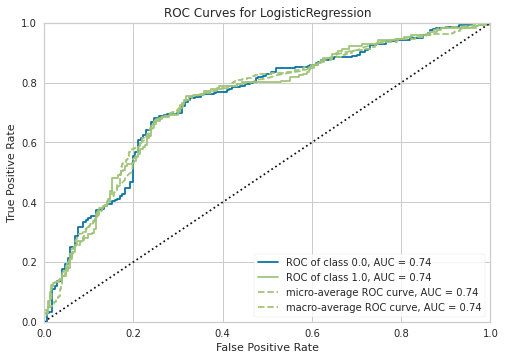

In [81]:
plot_model(model)

In [82]:
tuned_lda = tune_model(model
                      ,fold = 5
                      ,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7218,0.7464,0.6286,0.6875,0.6567,0.4236,0.4248
1,0.6855,0.7256,0.5619,0.6484,0.6020,0.3442,0.3466
2,0.6694,0.7126,0.5143,0.6353,0.5684,0.3052,0.3097
3,0.6895,0.7363,0.5769,0.6452,0.6091,0.3529,0.3545
4,0.6935,0.7302,0.4904,0.6892,0.5730,0.3445,0.3566
Mean,0.6919,0.7302,0.5544,0.6611,0.6019,0.3541,0.3584
Std,0.0170,0.0112,0.0485,0.0227,0.0317,0.0385,0.0373


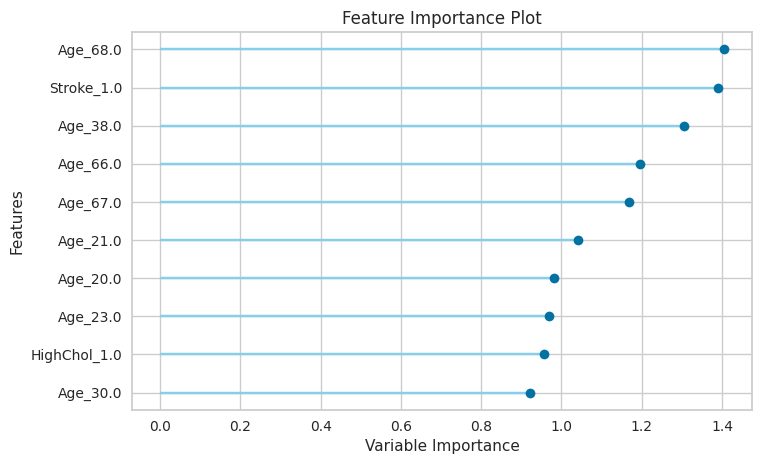

In [83]:
plot_model(estimator = tuned_lda, plot = 'feature')

In [84]:
predict_model(model, data=df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6765,0.7192,0.6340,0.6103,0.6219,0.3395,0.3397


,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Hemoglobin_concentration,Coronary_heart_disease,Stroke,Relative_heart_attack,Exercising,Sex,Age,Height_cm,Smoker,Label,Score
0,1.0,26.7,78.3,1.0,1.0,33.4,0.0,1.0,0.0,0.0,1,69,175.26,3.0,1.0,0.8407
1,1.0,28.6,89.5,1.0,1.0,32.5,0.0,0.0,0.0,0.0,1,54,180.34,2.0,1.0,0.5221
2,1.0,28.9,88.9,1.0,1.0,34.3,0.0,0.0,1.0,0.0,1,72,177.8,3.0,1.0,0.5934
5,1.0,41.7,105.0,1.0,1.0,34.2,1.0,0.0,0.0,1.0,1,56,162.56,3.0,1.0,0.7248
9,1.0,22.0,65.3,0.0,0.0,35.3,0.0,0.0,0.0,1.0,2,56,154.94,1.0,0.0,0.6367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9790,1.0,24.3,71.7,0.0,1.0,34.3,0.0,0.0,1.0,0.0,2,80,170.18,3.0,1.0,0.6956
9794,1.0,23.7,62.5,0.0,1.0,31.2,0.0,0.0,1.0,0.0,1,63,177.8,3.0,1.0,0.6574
9799,1.0,27.4,74.7,0.0,0.0,33.7,0.0,0.0,0.0,0.0,2,21,157.48,1.0,0.0,0.6134
9802,1.0,25.6,79.5,1.0,0.0,34.4,0.0,0.0,1.0,0.0,2,60,160.02,1.0,0.0,0.5886


In [85]:
final = finalize_model(model)

In [86]:
saved = save_model(final, 'model')

Transformation Pipeline and Model Successfully Saved


In [87]:
my_model = load_model('../data/model')

Transformation Pipeline and Model Successfully Loaded


In [88]:
# versao completa 
""" data_teste = pd.DataFrame()
data_teste['HighBP'] = [1]  
data_teste['HighChol'] = [1]
data_teste['BMI'] = [31]
data_teste['Smoker'] = [1] 
data_teste['Stroke'] = [1]
data_teste['HeartDiseaseorAttack'] = [1] 
data_teste['Fruits'] = [0] 
data_teste['Veggies'] = [0]
data_teste['HvyAlcoholConsump'] = [1]
data_teste['GenHlth'] = [5]
data_teste['Sex'] = [1]
data_teste['Age'] = [13]
data_teste['Drink_alcohol'] = [1]
data_teste['Weight_kg'] = [100]
data_teste['Systolic_bp'] = [135]
data_teste['Diastolic_bp'] = [60]
data_teste['Hemoglobin_concentration'] = [32]
data_teste['Congestive_heart_failure'] = [0]
data_teste['Coronary_heart_disease'] = [0]
data_teste['Angina'] = [0]
data_teste['Heart_attack'] = [0]
data_teste['Relative_heart_attack'] = [1]
data_teste['Exercising'] = [0]
data_teste['BP_status'] = [1]
data_teste['Height_cm'] = [180]
 """

# versao streaming - Saude Ruim
""" data_teste = pd.DataFrame()
#data_teste['HighBP'] = [1]  
data_teste['HighChol'] = [1]
data_teste['BMI'] = [31]
data_teste['Smoker'] = [1] 
data_teste['Stroke'] = [1]
data_teste['Fruits'] = [0] 
data_teste['Veggies'] = [0]
data_teste['Sex'] = [1]
data_teste['Age'] = [63]
data_teste['Drink_alcohol'] = [1]
data_teste['Weight_kg'] = [100]
data_teste['Hemoglobin_concentration'] = [32]
data_teste['Coronary_heart_disease'] = [0]
data_teste['Relative_heart_attack'] = [1]
data_teste['Exercising'] = [0]
data_teste['Height_cm'] = [180]
 """
# versao streaming - Saude Boa
data_teste = pd.DataFrame()
#data_teste['HighBP'] = [1]  
data_teste['HighChol'] = [0]
data_teste['BMI'] = [21]
data_teste['Smoker'] = [0] 
data_teste['Stroke'] = [0]
data_teste['Fruits'] = [1] 
data_teste['Veggies'] = [1]
data_teste['Sex'] = [1]
data_teste['Age'] = [33]
data_teste['Drink_alcohol'] = [0]
data_teste['Weight_kg'] = [54]
data_teste['Hemoglobin_concentration'] = [33]
data_teste['Coronary_heart_disease'] = [0]
data_teste['Relative_heart_attack'] = [0]
data_teste['Exercising'] = [1]
data_teste['Height_cm'] = [165]



#realiza a predição.
result = predict_model(my_model, data=data_teste)

#recupera os resultados.
classe = result["Label"][0]
prob = result["Score"][0]*100

print(classe)
print(prob)


1.0
93.98999810218811
